In [453]:
import torch
import torch.nn as nn
import cv2
import numpy as np

import gc
import os
import matplotlib.pyplot as plt
import time

from collections.abc import Iterable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torchvision.utils import make_grid

In [454]:
HEIGHT = 640
WIDTH = 400

gc.enable()

In [455]:
class ImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2LAB, transform=transforms.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(os.path.join(path, file)) for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]
            imgs = [np.uint8(img) for img in imgs]

        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
            return imgs
        else:
            return self.transform(self.imgs[subscript])

    def l_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[:1, :, :])
        return imgs

    def ab_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[1:, :, :])
        return imgs

#### Custom transformation class to resize images with ```OpenCV``` and later this class instance use with other transformation classes with ```transforms.Compose```.

In [456]:
class CustomResize(object):

    def __init__(self, size):
        assert isinstance(size, int) or isinstance(size, Iterable) and len(size) == 2
        self.size = size

    def __call__(self, pic):
        return cv2.resize(np.array(pic), dsize=self.size, interpolation=cv2.INTER_NEAREST)


In [457]:
tf = T.Compose({
    CustomResize(size=(WIDTH, HEIGHT)),
    T.ToTensor()
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
})

gray_dataset = ImageDataset(path='dataset/faces/grayscale', transform=tf, code=cv2.COLOR_BGR2GRAY)
rgb_dataset = ImageDataset(path='dataset/faces/color', transform=tf, code=cv2.COLOR_BGR2RGB)
lab_dataset = ImageDataset(path='dataset/faces/color', transform=tf, code=cv2.COLOR_BGR2LAB)

In [458]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [459]:
torch.manual_seed(101)

# GRAYSCALE IMAGES USE TO TRAIN NEURAL NETWORKS.
gray_data_loader = DataLoader(dataset=gray_dataset, batch_size=10, shuffle=True, pin_memory=is_cuda)
rgb_data_loader = DataLoader(dataset=rgb_dataset, batch_size=10, shuffle=False, pin_memory=is_cuda)
# LAB IMAGES FOR VISUALIZATION AND TRAINING PURPOSE.
lab_data_loader = DataLoader(dataset=lab_dataset, batch_size=10, shuffle=False, pin_memory=is_cuda)
l_data_loader = DataLoader(dataset=lab_dataset.l_images(), batch_size=10, shuffle=False, pin_memory=is_cuda)
ab_data_loader = DataLoader(dataset=lab_dataset.ab_images(), batch_size=10, shuffle=False ,pin_memory=is_cuda)

#### View a single batch grayscale and colored image sample.

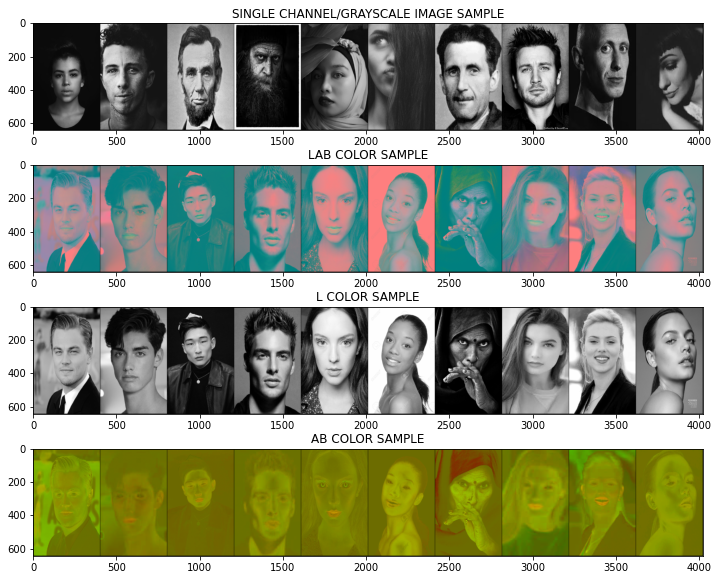

In [460]:
g_ims, l_ims, ab_ims, lab_ims, rgb_ims = (None, None, None, None, None)
for g_ims in gray_data_loader:
    break

for l_ims in l_data_loader:
    break

for ab_ims in ab_data_loader:
    break

for lab_ims in lab_data_loader:
    break

for rgb_ims in rgb_data_loader:
    break

plt.figure(figsize=(12, 10))

im = make_grid(g_ims, nrow=10, normalize=True)

plt.subplot(411)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("SINGLE CHANNEL/GRAYSCALE IMAGE SAMPLE")

im = make_grid(lab_ims, nrow=10, normalize=True)

plt.subplot(412)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("LAB COLOR SAMPLE")

im = make_grid(l_ims, nrow=10, normalize=True)

plt.subplot(413)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title("L COLOR SAMPLE")

im = make_grid(ab_ims, nrow=10, normalize=True)
im = np.stack([im[0], im[1], np.zeros((im.shape[1], im.shape[2]))])

plt.subplot(414)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title('AB COLOR SAMPLE')

plt.show()

In [461]:
device = torch.device('cuda' if is_cuda else 'cpu')
device

device(type='cuda')

####  Convolutional Neural Network Model

In [464]:
class ColorizingNet(nn.Module):

    def __init__(self, in_features=1, out_features=2):
        super().__init__()

        resnet = models.resnet34(pretrained=True)
        # Change the first convolutional layer to accept single channel images.
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(dim=1))

        # ResNet-34 number of output features.
        self.resnet_out_channels = 128

        self.in_features = in_features
        self.out_features = out_features

        self.resnet = nn.Sequential(*list(resnet.children())[:-4])
        self.localize_sequence = self.localize_layer((128, 64, 32, 16, 8, 4))

    def localize_layer(self, n_layers):
        layers, n_in = [], self.resnet_out_channels

        for i, nl in enumerate(n_layers):
            i += 1

            layers.append(nn.Conv2d(in_channels=n_in,
                                    out_channels=nl,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1))
            layers.append(nn.BatchNorm2d(nl))
            layers.append(nn.ReLU())
            layers.append(nn.Upsample(scale_factor=2.))

            if i % 2 == 0:
                layers.append(nn.AvgPool2d(kernel_size=2, stride=2))

            n_in = nl

        layers.append(nn.Conv2d(in_channels=n_in,
                                out_channels=self.out_features,
                                kernel_size=3,
                                stride=1, padding=1))

        return nn.Sequential(*layers)

    def forward(self, X):
        X = self.resnet(X)
        return self.localize_sequence(X)


model = ColorizingNet()

if is_cuda:
  model = model.cuda()
model

ColorizingNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [463]:
with torch.no_grad():

    model.eval()

    s = model(l_ims[0].to(device).view(-1, 1, HEIGHT, WIDTH))
    print(s.shape)

# s = torch.stack([l_ims[0][0], s[0, 0].cpu(), s[0, 1].cpu()]) * 255
# s = np.transpose(s.detach().view(-1, HEIGHT, WIDTH).numpy(), axes=(1, 2, 0)).astype(np.uint8)
# s = cv2.cvtColor(s, code=cv2.COLOR_LAB2RGB)

torch.Size([1, 2, 640, 400])


In [465]:
count = 0
for params in model.parameters():
  count += params.numel()

count

1588126

#### Training Neural Network Models

In [466]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [467]:
epoch = 3
losses = []

start = time.time()

for i in range(epoch):
    i += 1

    batch_time = time.time()

    for batch, (X, y) in enumerate(zip(l_data_loader, ab_data_loader)):
        batch += 1

        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)
        loss = criterion(y_pred, y)

        losses.append(loss)

        if batch % 5 == 0 or batch == 1:
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

duration = time.time() - start
print(f'Duration to total execution: {duration / 60:.2f} minutes')

Epoch: 1, Batch: 1 -> Loss: 0.21746376156806946
Epoch: 1, Batch: 5 -> Loss: 0.0953235998749733
Epoch: 1, Batch: 10 -> Loss: 0.050641294568777084
Epoch: 1, Batch: 15 -> Loss: 0.03036711923778057
Epoch: 1, Batch: 20 -> Loss: 0.015912093222141266
Epoch: 2, Batch: 1 -> Loss: 0.014618548564612865
Epoch: 2, Batch: 5 -> Loss: 0.010899103246629238
Epoch: 2, Batch: 10 -> Loss: 0.0061278147622942924
Epoch: 2, Batch: 15 -> Loss: 0.004747455473989248
Epoch: 2, Batch: 20 -> Loss: 0.003641990479081869
Epoch: 3, Batch: 1 -> Loss: 0.003541339887306094
Epoch: 3, Batch: 5 -> Loss: 0.0030812143813818693
Epoch: 3, Batch: 10 -> Loss: 0.002523548901081085
Epoch: 3, Batch: 15 -> Loss: 0.002016322920098901
Epoch: 3, Batch: 20 -> Loss: 0.002247672062367201
Duration to total execution: 0.88 minutes


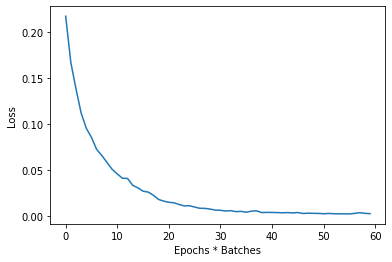

In [468]:
plt.plot(losses)
plt.xlabel('Epochs * Batches')
plt.ylabel('Loss')

del losses

In [446]:
# torch.save(model.state_dict(), '../state_dict/colorizing_net.pth')

#### Validate images with same dataset used to train.

In [469]:
@torch.no_grad()
def validate(img):

    model.eval()

    ab = model(img.to(device))

    lab = np.stack([img[0, 0], ab.cpu()[0, 0], ab.cpu()[0, 1]], axis=0) * 255

    lab = np.transpose(lab, axes=(1, 2, 0)).astype(np.uint8)
    lab = cv2.cvtColor(lab, code=cv2.COLOR_LAB2RGB)

    plt.imshow(lab)

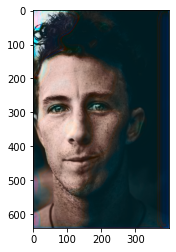

In [470]:
validate(g_ims[1].view(-1, 1, HEIGHT, WIDTH))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3843) tensor(-0.7176)


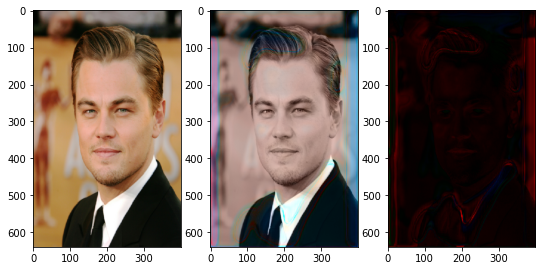

In [471]:
IMG_INDEX = 0

with torch.no_grad():

    model.eval()

    plt.figure(figsize=(9, 8))
    plt.subplot(131)
    plt.imshow(np.transpose(rgb_ims[IMG_INDEX], axes=(1, 2, 0)))

    s = model(l_ims[IMG_INDEX].to(device).view(-1, 1, HEIGHT, WIDTH))
    s = torch.stack([l_ims[IMG_INDEX][0], s[0, 0].cpu(), s[0, 1].cpu()]) * 255
    s = np.transpose(s.detach().view(-1, HEIGHT, WIDTH).numpy(), axes=(1, 2, 0)).astype(np.uint8)
    s = cv2.cvtColor(s, code=cv2.COLOR_LAB2RGB)

    plt.subplot(132)
    plt.imshow(s)

    org = np.transpose(rgb_ims[IMG_INDEX], axes=(1, 2, 0))
    pred = torch.Tensor(s) / 255

    diff = torch.sub(input=org, other=pred)

    print(diff[:, :, 2].max(), diff[:, :, 2].min())

    plt.subplot(133)
    plt.imshow(diff)